# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
% matplotlib inline
from fuzzywuzzy import process, fuzz
import sys

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Join Crime Data

## Read in Raw School Data

In [53]:
schools = pd.read_pickle('../data/schools_w_social.pkl')

In [54]:
schools.head()

,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,School_Hours,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,Graduation_Rate_School,fb_likes,tw_followers,tw_tweets
10,609764,JUAREZ HS,Benito Juarez Community Academy High School,Neighborhood,60608,NaN,NaN,1739,1659,7:45 AM - 2:35 PM,"Blue, Pink, Red",41.852667,-87.663732,16.5,80.9,NaN,NaN,NaN
11,400054,NOBLE - PRITZKER HS,Noble - Pritzker College Prep,Charter,60639,https://www.facebook.com/benoblepritzker,http://twitter.com/benoblepritzker,992,936,M - R 8:05AM. - 3:50PM F 8:05- 1:30PM,"Blue, Brown",41.915214,-87.730127,21.9,90.3,1793.0,275.0,448.0
12,609726,BROOKS HS,Gwendolyn Brooks College Preparatory Academy HS,Selective enrollment,60628,NaN,https://twitter.com/BrooksPrepCSL,959,692,8:00 AM - 3:30 PM,Orange,41.692763,-87.616353,22.5,93.4,NaN,408.0,3869.0
14,400094,EPIC HS,EPIC Academy Charter High School,Charter,60617,https://www.facebook.com/EPICAcademyHighSchool,https://twitter.com/EPIC_Academy,523,491,8:10 AM-3:50 PM,NaN,41.744849,-87.550222,17.5,69.9,424.0,305.0,787.0
21,609755,YOUNG HS,Whitney M Young Magnet High School,Selective enrollment,60607,http://www.facebook.com/wmymhs,http://www.twitter.com/wyhs,2156,891,8:00 AM - 3:15 PM,Blue,41.878603,-87.664233,27.9,96.2,4004.0,1708.0,999.0


### Visualize School Locations

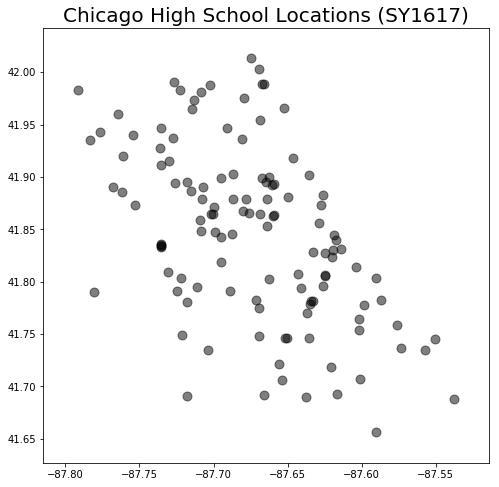

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Chicago High School Locations (SY1617)', size=20)

plt.scatter(schools['School_Longitude'], schools['School_Latitude'], alpha=0.5, c='k', s=80);

## Read in Raw Crime Data

In [49]:
crimes = pd.read_pickle('../data/cleaned_crimes.pkl')

In [50]:
crimes.head()

,ID,Date,Primary Type,Arrest,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude
0,10801165,01/01/2017 01:00:00 AM,BATTERY,True,8,1175950.0,1908370.0,41.903933,-87.629129
1,10801166,01/01/2017 01:23:00 AM,PUBLIC PEACE VIOLATION,True,71,1171453.0,1848804.0,41.740579,-87.647394
2,10801090,01/01/2017 12:01:00 AM,CRIMINAL DAMAGE,False,42,1187984.0,1862596.0,41.778047,-87.586388
3,10801213,01/01/2017 01:00:00 AM,BATTERY,False,30,1158068.0,1888177.0,41.848906,-87.695365
4,10801214,01/01/2017 01:45:00 AM,CRIMINAL DAMAGE,True,5,1162249.0,1928318.0,41.958969,-87.678896


### Visualize School Locations with Crime

In [51]:
X_crime = crimes.loc[:, 'Longitude']
Y_crime = crimes.loc[:, 'Latitude']

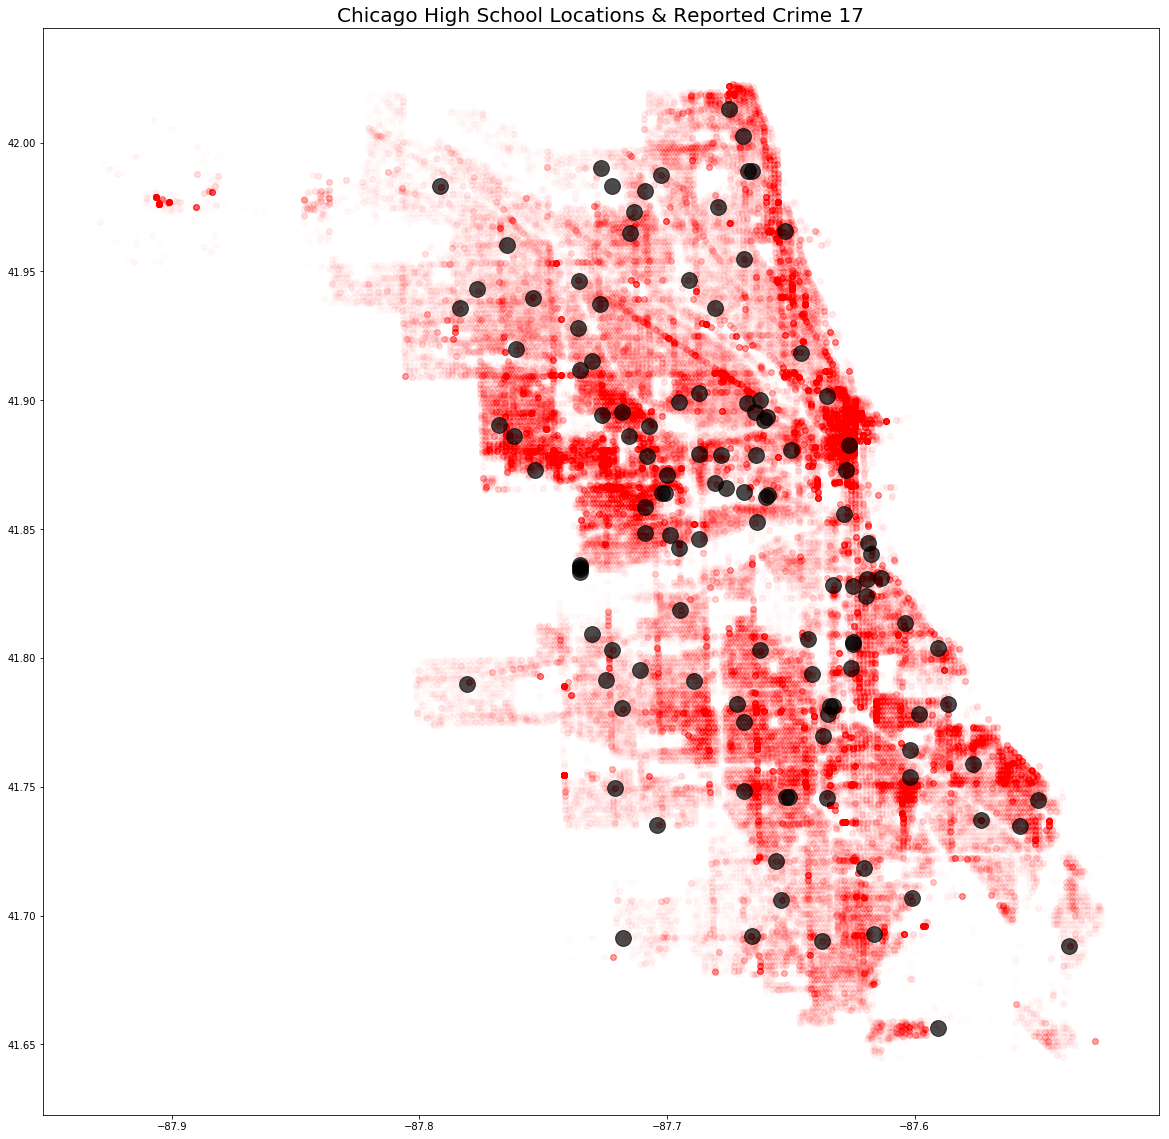

In [56]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title('Chicago High School Locations & Reported Crime 17', size=20)

plt.scatter(X_crime, Y_crime, alpha=0.01, c='r')
plt.scatter(schools['School_Longitude'], schools['School_Latitude'], alpha=0.7, c='k', s=250);

### Count Crimes on School Block

In [17]:
def zip_coordinates(df, lat_col, lon_col, id_col):
    """
    Take a df and column names for the lat/long and id of observations you would like to zip 
    and return a list of tuples with the identifier and lat/long coordinates
    """
    lats = list(df[lat_col])
    lons = list(df[lon_col])
    coords = list(zip(lats, lons))
    
    bound = list(zip(df[id_col], coords))
    
    return bound

In [18]:
def count_nearby_crimes(school_list, crime_list, radius_max=0.125):
    """
    Take a list of coordinates for schools and list of crimes with coordinates to find the count
    of crimes within some radius of each school. Returns list of crimes the length of the school list
    """
    
    # Count crimes within .125 (~1 city block) of the school 
    nearby_crime_ct = []

    for index, school in enumerate(school_list):

        crime_count = 0

        for index, crime in enumerate(crime_list):
            distance = great_circle(school[1], crime[1]).miles

            if distance < radius_max:
                crime_count += 1

        nearby_crime_ct.append(crime_count)
        
    return nearby_crime_ct

In [19]:
school_list = zip_coordinates(df=schools, 
                              id_col='School_ID',
                              lat_col='School_Latitude',
                              lon_col='School_Longitude')

crimes_list = zip_coordinates(df=crimes, 
                              id_col='ID',
                              lat_col='Latitude',
                              lon_col='Longitude')

nearby_crimes = count_nearby_crimes(school_list=school_list, crime_list=crimes_list)

In [23]:
print(len(nearby_crimes))

121


In [57]:
schools['crime_counts'] = nearby_crimes

In [58]:
schools.sort_values('crime_counts', ascending=False)

,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,School_Hours,Transportation_El,School_Latitude,School_Longitude,Average_ACT_School,Graduation_Rate_School,fb_likes,tw_followers,tw_tweets,crime_counts
554,400098,NOBLE - MUCHIN HS,Noble - Muchin College Prep,Charter,60602,http://www.facebook.com/BeNobleMuchin,https://twitter.com/BeNobleMuchin,964,804,"M- R 7:50 AM - 3:53 PM, F 7:50 AM - 12:25 PM","Blue, Brown, Green, Orange, Pink, Purple, Red",41.882740,-87.626338,21.8,86.4,600.0,287.0,421.0,2145
476,609678,JONES HS,William Jones College Preparatory High School,Selective enrollment,60605,https://www.facebook.com/JonesCollegePrepHS/,https://twitter.com/jonescollegehs,1866,732,8:00 am - 3:15 pm,"Blue, Brown, Pink, Red",41.873066,-87.627675,26.2,91.8,NaN,455.0,549.0,348
36,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,"M - R 8:00 a.m. - 4:00 p.m., F 8:30 a.m. - 1:3...","Blue, Brown, Green",41.895362,-87.718047,18.5,82.4,427.0,187.0,205.0,333
55,400058,NORTH LAWNDALE - CHRISTIANA HS,North Lawndale College Prep - Christiana,Charter,60623,https://www.facebook.com/nlcphs,NaN,357,349,8:00 a.m. - 3:30 p.m.,Green,41.858564,-87.708987,15.3,67.1,1419.0,NaN,NaN,229
352,610389,ORR HS,Orr Academy High School,Neighborhood,60624,https://www.facebook.com/orracademyhighschool,https://twitter.com/orracademy,276,263,"7:45am - 2:42pm (M,T,TH,F); 7:45am - 1:32pm (W)",NaN,41.894449,-87.726166,14.2,39.0,424.0,213.0,70.0,199
29,610518,AUSTIN CCA HS,Austin College and Career Academy High School,Small,60644,NaN,https://twitter.com/ACCAChicago,223,216,8:40 AM - 3:53 PM,Green,41.885993,-87.761916,14.6,70.9,NaN,65.0,184.0,184
38,610394,UPLIFT HS,Uplift Community High School,Small,60640,NaN,https://twitter.com/UpliftTitans,245,229,8:30 AM - 3:38 PM,Red,41.965547,-87.652473,15.6,74.3,NaN,27.0,48.0,175
138,400105,URBAN PREP - BRONZEVILLE HS,Urban Prep Academy for Young Men - Bronzeville,Charter,60616,https://www.facebook.com/UrbanPrepAcademies/,NaN,322,262,8:30 AM-4:30 PM,"Green, Red",41.831118,-87.613629,16.6,82.4,11744.0,NaN,NaN,174
191,609754,CHICAGO MILITARY HS,Chicago Military Academy High School,Military academy,60653,NaN,NaN,313,295,7:30 am-3:05 pm,"Green, Red",41.830555,-87.619216,16.9,85.4,NaN,NaN,NaN,173
206,609722,MANLEY HS,Manley Career Academy High School,Neighborhood,60612,https://www.facebook.com/manleyhighschool,NaN,113,105,9:00 AM - 4:23 PM,Blue,41.870939,-87.699896,14.1,57.9,152.0,NaN,NaN,154


In [59]:
schools.reset_index(drop=True, inplace=True)

## Deal with Outliers

### Identify Outliers

It looks like there are a few schools at the top with a really high count of crime - let's see what this distribution looks like on a density plot

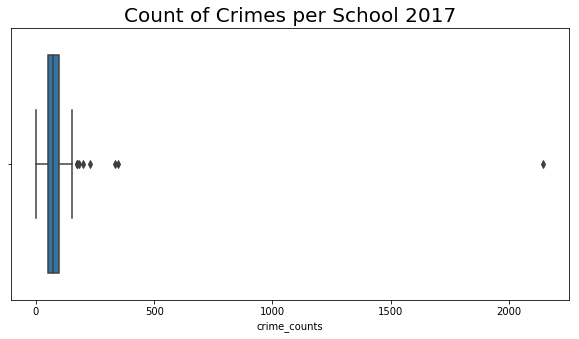

In [60]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(schools['crime_counts'])
ax.set_title('Count of Crimes per School 2017', size=20)
plt.show();

Ok, so the top outlier is a school in the loop by Washington and State (high density area with crime likely unrelated to the school - let's find the outher statistical outliers of schools by crime and checkout out where these schools are located

In [61]:
schools['crime_counts'].describe()

count     121.000000
mean       98.214876
std       195.082897
min         1.000000
25%        50.000000
50%        71.000000
75%        99.000000
max      2145.000000
Name: crime_counts, dtype: float64

In [62]:
def find_outliers(series, multiplier=1.5):
    """
    Takes as input a series, identifies the outliers as defined as 1.5 * IQR from the .75 Q and return a mask to identify them
    """
    adjusted_IQR = (series.quantile(.75) - series.quantile(.25)) * multiplier
    outlier_lim = series.quantile(.75) + adjusted_IQR
    print(outlier_lim)
    
    outliers = [True if x > outlier_lim else False for x in series]
    
    outlier_count = sum(outliers)
    all_data_count = len(series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,6)))
    
    return outliers
    

In [63]:
crime_outliers = find_outliers(schools['crime_counts'])
schools['crime_outlier'] = crime_outliers

172.5
9 outliers identified: 0.07438 of all data


Ok, so there are 9 data points that are statistical outliers...but it might be real data so I don't want to throw them all away out of hand. Let's check out where the outliers are located and compare the crime count to other schools nearby to see if they seem reasonable

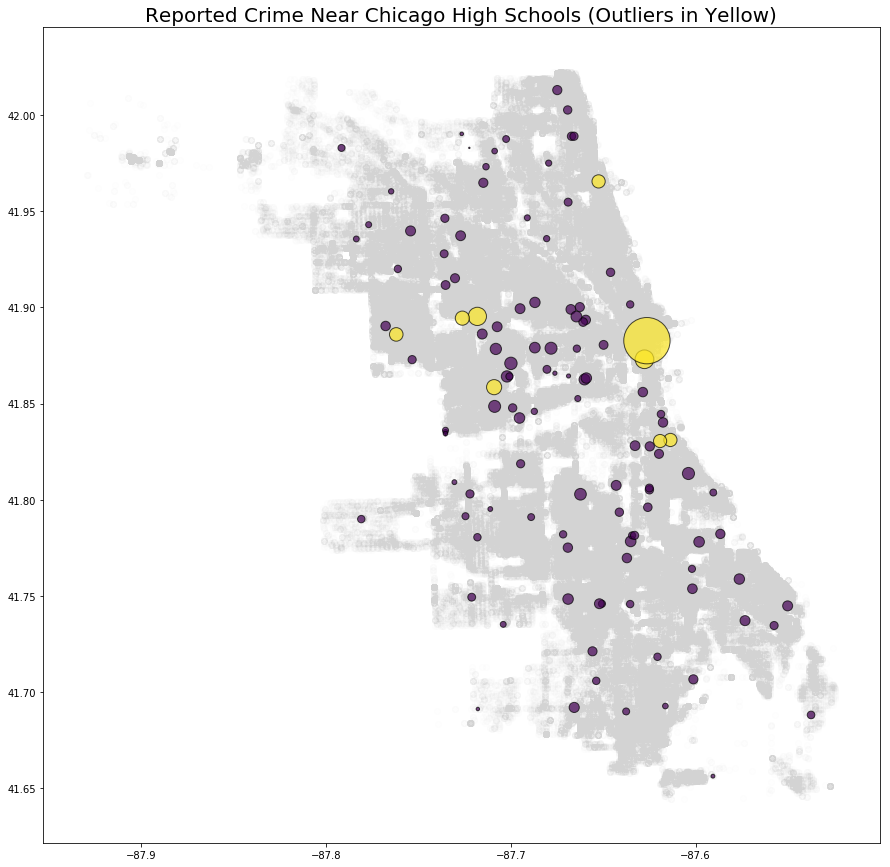

In [73]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Reported Crime Near Chicago High Schools (Outliers in Yellow)', size=20)

plt.scatter(X_crime, Y_crime, alpha=0.01, c='lightgrey')
plt.scatter(schools['School_Longitude'], schools['School_Latitude'], alpha=0.7, 
            c=schools['crime_outlier'], edgecolors='k',
            s=schools['crime_counts']);

### Replace Outliers w Mean

Ok, so the two largest dots situated in the loop stick out to me because:
- They are situated in highly dense areas where crimes unrelated to the school are very likely occuring within 1 city block of the school location
- These two outliers are not near other, similarly sized dots while the rest of the outliers appear to be relatively consistent with surrounding schools

For now, I'm going to replace these two crime counts with the median count for the dataset

In [75]:
sorted_schools = schools.sort_values('crime_counts', ascending=False)
sorted_schools.reset_index(inplace=True)

sorted_schools['crime_counts'].head()

0    2145
1     348
2     333
3     229
4     199
Name: crime_counts, dtype: int64

In [76]:
def replace_top_X_mean(series, indices_to_replace):
    
    others = series
    to_replace = []
    
    for i in indices_to_replace:
        to_replace.append(others.pop(i))
    
    for i, c in enumerate(to_replace):
        to_replace[i] = int(others.mean())
        
    to_replace.extend(others)
        
    return to_replace


In [77]:
sorted_schools['crime_counts'] = replace_top_X_mean(sorted_schools['crime_counts'], [0,1])

In [78]:
sorted_schools['crime_counts'].head()

0     78
1     78
2    333
3    229
4    199
Name: crime_counts, dtype: int64

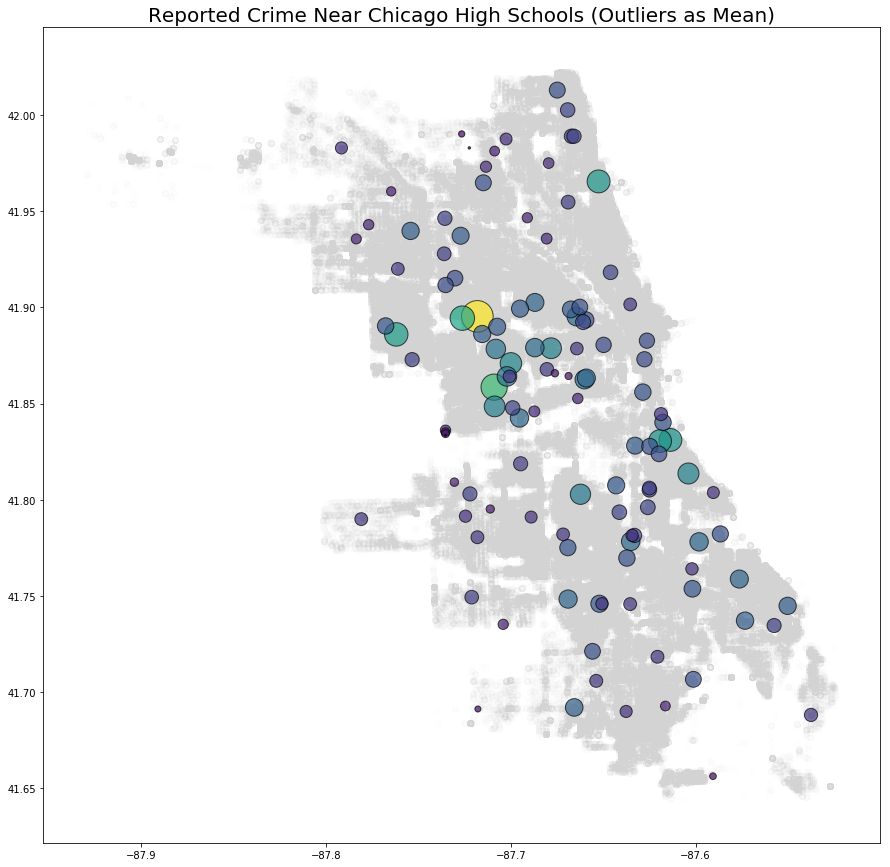

In [89]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Reported Crime Near Chicago High Schools (Outliers as Mean)', size=20)

scalar = 3
plt.scatter(X_crime, Y_crime, alpha=0.01, c='lightgrey')
plt.scatter(sorted_schools['School_Longitude'], sorted_schools['School_Latitude'], alpha=0.7, 
            c=sorted_schools['crime_counts'], edgecolors='k',
            s=sorted_schools['crime_counts']*scalar);

## Normalize Crime Data To School Size

Because these schools vary in size, I want to normalize the count of crimes taking place around the school by finding the count of crimes per student

In [80]:
sorted_schools['crimes_per_student'] = [(crimes/students) for (crimes, students) 
                                                        in zip(sorted_schools['crime_counts'], sorted_schools['Student_Count_Total'])]

# I'll also compute crimes per 1000 students for the sake of plotting
sorted_schools['crimes_per_1000_students'] = [crimes * 1000 for crimes in sorted_schools['crimes_per_student']]

Lets see how this changes our map view

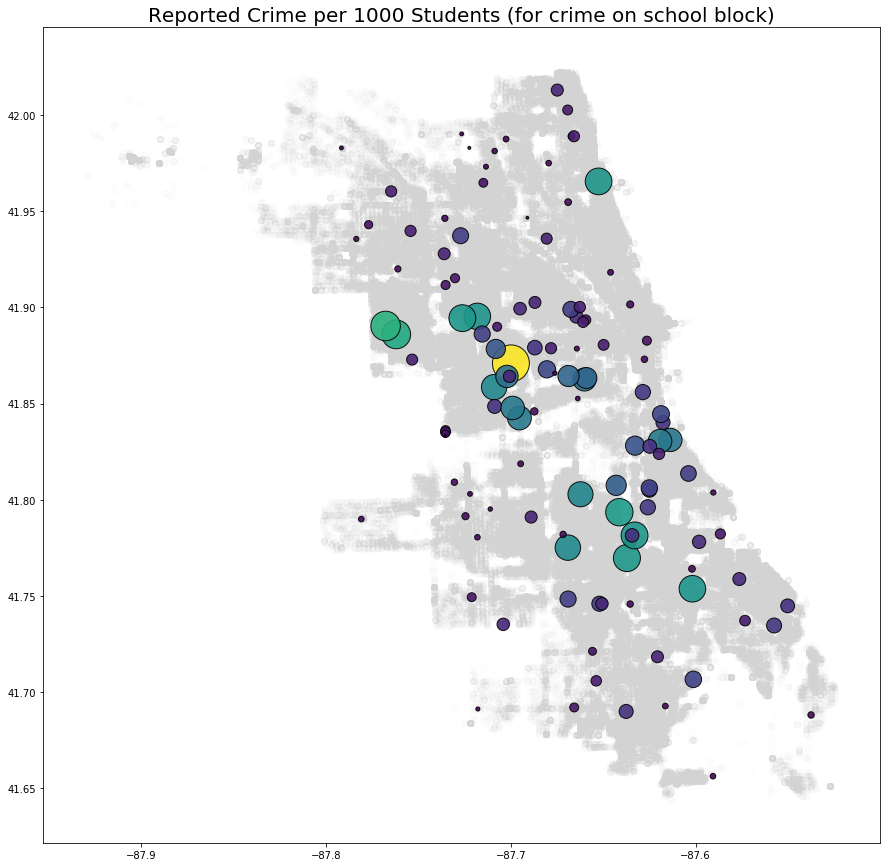

In [84]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_title('Reported Crime per 1000 Students (for crime on school block)', size=20)

plt.scatter(X_crime, Y_crime, alpha=0.01, c='lightgrey')
plt.scatter(sorted_schools['School_Longitude'], sorted_schools['School_Latitude'], alpha=0.9, 
            c=sorted_schools['crimes_per_1000_students'], edgecolors='k',
            s=sorted_schools['crimes_per_1000_students']);

## Pickle Joined School & Crime Data

In [85]:
sorted_schools.to_pickle('../data/schools_crimes.pkl')

# Join Budget Data

## Read in School & Crime Data Join

In [91]:
schools = pd.read_pickle('../data/schools_crimes.pkl')

In [92]:
schools.head()

,index,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,...,School_Longitude,Average_ACT_School,Graduation_Rate_School,fb_likes,tw_followers,tw_tweets,crime_counts,crime_outlier,crimes_per_student,crimes_per_1000_students
0,100,400098,NOBLE - MUCHIN HS,Noble - Muchin College Prep,Charter,60602,http://www.facebook.com/BeNobleMuchin,https://twitter.com/BeNobleMuchin,964,804,...,-87.626338,21.8,86.4,600.0,287.0,421.0,78,True,0.080913,80.912863
1,91,609678,JONES HS,William Jones College Preparatory High School,Selective enrollment,60605,https://www.facebook.com/JonesCollegePrepHS/,https://twitter.com/jonescollegehs,1866,732,...,-87.627675,26.2,91.8,NaN,455.0,549.0,78,True,0.041801,41.800643
2,8,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,...,-87.718047,18.5,82.4,427.0,187.0,205.0,333,True,0.702532,702.531646
3,10,400058,NORTH LAWNDALE - CHRISTIANA HS,North Lawndale College Prep - Christiana,Charter,60623,https://www.facebook.com/nlcphs,NaN,357,349,...,-87.708987,15.3,67.1,1419.0,NaN,NaN,229,True,0.641457,641.456583
4,66,610389,ORR HS,Orr Academy High School,Neighborhood,60624,https://www.facebook.com/orracademyhighschool,https://twitter.com/orracademy,276,263,...,-87.726166,14.2,39.0,424.0,213.0,70.0,199,True,0.721014,721.014493


## Read in Raw Budget Data

In [93]:
budget = pd.read_pickle('../data/budget_raw.pkl')

In [94]:
budget.head()

,School,2016-17,2015-16,Pct. Change,New Budget,Budget Change
0,Chicago Vocational High School,922,978,-5.73%,"$8,316,708","-$235,904"
1,Dunbar High School,563,761,-26.02%,"$6,216,418","-$88,989"
2,Jones High School,1820,1670,8.98%,"$11,061,717","-$231,475"
3,Prosser High School,1381,1455,-5.09%,"$10,986,115","-$156,831"
4,Payton High School,981,887,10.60%,"$6,720,149","-$109,332"


## Clean School Names for Joining

I'm basically just removing the word 'High School' from the school name in each dataset

In [95]:
def clean_school_name(df, name_col):
    """
    Takes in a dataframe and column name to be cleaned and returns a standard format 
    to be used in name matching
    """
    
    clean_names = []
    
    for name in df[name_col]:
        
        rm_hs = name.replace('High School', '').replace('HS', '').strip()
        cleaned = rm_hs.translate(str.maketrans("", "", ",.-'\"():;+/?$°@"))
        clean_names.append(cleaned.lower())
        
    return clean_names

In [96]:
schools['cleaned_name'] = clean_school_name(schools, 'Long_Name')
budget['cleaned_name'] = clean_school_name(budget, 'School')

## Join On Fuzzy String Match

In [121]:
def find_best_matches(df_1, df_2, match_col_1, match_col_2, cutoff=80, scorer=fuzz.token_set_ratio):
    
    """
    Takes in two dataframes and the name of a key column to join on, 
    identifies the best match and returns a list of indices for the best matches 
    in df_2 to all rows in df_1
    """
    
    best_matches = []
    
    for index, row in df_1.iterrows():
    
        match = process.extractOne(
                        df_1.loc[index, match_col_1].lower(), 
                        choices=df_2.loc[:, match_col_2].str.lower(), 
                        scorer=scorer,
                        score_cutoff=cutoff)
        
        best_matches.append(match)

    return best_matches

I'm choosing to set the default scorer to the fuzzy wuzzy package's token_set_ratio method because it will subset each string into it's component parts, find the components that are contained in the set of target components and then score the remainder (order does not matter)

Example:
```python
>>> fuzz.token_sort_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
    84
>>> fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
    100
```
https://github.com/seatgeek/fuzzywuzzy

In [123]:
schools['matches'] = find_best_matches(df_1=schools, 
                                       df_2=budget, 
                                       match_col_1='cleaned_name',
                                       match_col_2='cleaned_name',
                                       cutoff=90)

schools['match_id'] = [int(x[2]) if x is not None else None 
                       for x in schools['matches']]

In [124]:
schools.head()

,index,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,...,tw_followers,tw_tweets,crime_counts,crime_outlier,crimes_per_student,crimes_per_1000_students,cleaned_name,matches,match_id,school_match_count
0,100,400098,NOBLE - MUCHIN HS,Noble - Muchin College Prep,Charter,60602,http://www.facebook.com/BeNobleMuchin,https://twitter.com/BeNobleMuchin,964,804,...,287.0,421.0,78,True,0.080913,80.912863,noble muchin college prep,None,NaN,NaN
1,91,609678,JONES HS,William Jones College Preparatory High School,Selective enrollment,60605,https://www.facebook.com/JonesCollegePrepHS/,https://twitter.com/jonescollegehs,1866,732,...,455.0,549.0,78,True,0.041801,41.800643,william jones college preparatory,"(jones, 100, 2)",2.0,1.0
2,8,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,...,187.0,205.0,333,True,0.702532,702.531646,noble roweclark math and science academy,None,NaN,NaN
3,10,400058,NORTH LAWNDALE - CHRISTIANA HS,North Lawndale College Prep - Christiana,Charter,60623,https://www.facebook.com/nlcphs,NaN,357,349,...,NaN,NaN,229,True,0.641457,641.456583,north lawndale college prep christiana,"(lawndale, 100, 246)",246.0,3.0
4,66,610389,ORR HS,Orr Academy High School,Neighborhood,60624,https://www.facebook.com/orracademyhighschool,https://twitter.com/orracademy,276,263,...,213.0,70.0,199,True,0.721014,721.014493,orr academy,"(orr, 100, 467)",467.0,1.0


### Checking For Schools with No Budget Records
Which schools were not matched with a budget row

In [135]:
unmatched_schools = schools.loc[schools['match_id'].isnull(), :].copy()

In [136]:
print(len(unmatched_schools), 'Schools don\'t have a corresponding budget row')

32 Schools don't have a corresponding budget row


In [137]:
unmatched_schools['cleaned_name']

0                           noble  muchin college prep
2            noble  roweclark math and science academy
5                    austin college and career academy
12                   noble  chicago bulls college prep
17                          noble  golder college prep
21                        consuella b york alternative
22                                 cics  ralph ellison
29                                epic academy charter
31                    perspectives  leadership academy
32                       chicago  for the arts chiarts
35                aspira charter school  early college
41                       perspectives  rodney d joslin
43                                 ogden international
46              perspectives  math and science academy
50                           noble  noble college prep
51                                      cics  longwood
54                      chicago virtual charter school
56                          noble  rauner college prep
57        

Let's try to do the fuzzy match on the schools short name instead of the long name to see if we can match any more of these

>Example: 
> **albert g lane technical** above needs to match with **Lane Tech** in the budget data - *I didn't even see that at first*

In [138]:
unmatched_schools['short_matches'] = find_best_matches(df_1=unmatched_schools, 
                                                       df_2=budget, 
                                                       match_col_1='Short_Name', 
                                                       match_col_2='cleaned_name', 
                                                       cutoff=90)

unmatched_schools['short_match_id'] = [int(x[2]) if x is not None else None 
                       for x in unmatched_schools['short_matches']]

In [151]:
newly_resolved = unmatched_schools[~unmatched_schools['short_match_id'].isnull()]
newly_resolved

,index,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,...,crime_counts,crime_outlier,crimes_per_student,crimes_per_1000_students,cleaned_name,matches,match_id,school_match_count,short_matches,short_match_id
2,8,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,...,333,True,0.702532,702.531646,noble roweclark math and science academy,None,NaN,NaN,"(clark, 100, 402)",402.0
65,120,610390,RICKOVER MILITARY HS,Hyman G Rickover Naval Academy High School,Military academy,60660,NaN,NaN,556,494,...,68,False,0.122302,122.302158,hyman g rickover naval academy,None,NaN,NaN,"(rickover military, 100, 468)",468.0
105,47,609720,LANE TECH HS,Albert G Lane Technical High School,Selective enrollment,60618,http://www.facebook.com/LaneTechHS,http://twitter.com/LaneTech1440,4447,2191,...,35,False,0.007870,7.870474,albert g lane technical,None,NaN,NaN,"(lane tech, 100, 25)",25.0
107,84,609749,NORTHSIDE PREP HS,Northside College Preparatory High School,Selective enrollment,60625,NaN,https://twitter.com/northsidecphs,1062,470,...,32,False,0.030132,30.131827,northside college preparatory,None,NaN,NaN,"(northside prep, 100, 45)",45.0
118,85,609753,CHICAGO AGRICULTURE HS,Chicago High School for Agricultural Sciences,Magnet,60655,NaN,https://twitter.com/chicagoaghs,723,325,...,12,False,0.016598,16.597510,chicago for agricultural sciences,None,NaN,NaN,"(chicago agriculture, 100, 47)",47.0


In [152]:
print("""Ok, we were able to resolve {} more schools to the budget data,
        let's merge that back into the original df"""
      .format(len(newly_resolved)))

Ok, we were able to resolve 5 more schools to the budget data,
        let's merge that back into the original df


In [157]:
for index, row in newly_resolved.iterrows():
    print(index)
    schools.loc[index, 'matches'] = str(row.short_matches)
    schools.loc[index, 'match_id'] = row.short_match_id

2
65
105
107
118


In [158]:
schools.loc[65]

index                                                              120
School_ID                                                       610390
Short_Name                                        RICKOVER MILITARY HS
Long_Name                   Hyman G Rickover Naval Academy High School
School_Type                                           Military academy
Zip                                                              60660
Facebook                                                           NaN
Twitter                                                            NaN
Student_Count_Total                                                556
Student_Count_Low_Income                                           494
School_Hours                                     8:15 a.m. - 3:20 p.m.
Transportation_El                                                  Red
School_Latitude                                                 41.989
School_Longitude                                              -87.6658
Averag

### Checking For Duplicated Budget Records
Let's make sure there aren't multiple schools matching to a single budget entry

In [160]:
distinct_matches = schools.groupby('match_id')['School_ID'].nunique()
distinct_matches.sort_values(ascending=False).head(10)

match_id
49.0     6
246.0    3
41.0     2
445.0    2
402.0    2
4.0      1
1.0      1
23.0     1
24.0     1
25.0     1
Name: School_ID, dtype: int64

Oofph, I need to investigate the first 5 matches there... let's add a column with these match counts for every match_id so I can look at them in more detail

In [161]:
schools['school_match_count'] = [distinct_matches[x] if not np.isnan(x) else None 
                                 for x in schools['match_id']]

In [162]:
schools.head()

,index,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,...,tw_followers,tw_tweets,crime_counts,crime_outlier,crimes_per_student,crimes_per_1000_students,cleaned_name,matches,match_id,school_match_count
0,100,400098,NOBLE - MUCHIN HS,Noble - Muchin College Prep,Charter,60602,http://www.facebook.com/BeNobleMuchin,https://twitter.com/BeNobleMuchin,964,804,...,287.0,421.0,78,True,0.080913,80.912863,noble muchin college prep,None,NaN,NaN
1,91,609678,JONES HS,William Jones College Preparatory High School,Selective enrollment,60605,https://www.facebook.com/JonesCollegePrepHS/,https://twitter.com/jonescollegehs,1866,732,...,455.0,549.0,78,True,0.041801,41.800643,william jones college preparatory,"(jones, 100, 2)",2.0,1.0
2,8,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,...,187.0,205.0,333,True,0.702532,702.531646,noble roweclark math and science academy,"('clark', 100, 402)",402.0,2.0
3,10,400058,NORTH LAWNDALE - CHRISTIANA HS,North Lawndale College Prep - Christiana,Charter,60623,https://www.facebook.com/nlcphs,NaN,357,349,...,NaN,NaN,229,True,0.641457,641.456583,north lawndale college prep christiana,"(lawndale, 100, 246)",246.0,3.0
4,66,610389,ORR HS,Orr Academy High School,Neighborhood,60624,https://www.facebook.com/orracademyhighschool,https://twitter.com/orracademy,276,263,...,213.0,70.0,199,True,0.721014,721.014493,orr academy,"(orr, 100, 467)",467.0,1.0


### Manually resolve as best as possible

In [164]:
matches = pd.merge(schools, budget, how='outer', 
                  left_on='match_id', right_index=True)

In [165]:
print(len(matches))
matches.columns

538


Index(['index', 'School_ID', 'Short_Name', 'Long_Name', 'School_Type', 'Zip',
       'Facebook', 'Twitter', 'Student_Count_Total',
       'Student_Count_Low_Income', 'School_Hours', 'Transportation_El',
       'School_Latitude', 'School_Longitude', 'Average_ACT_School',
       'Graduation_Rate_School', 'fb_likes', 'tw_followers', 'tw_tweets',
       'crime_counts', 'crime_outlier', 'crimes_per_student',
       'crimes_per_1000_students', 'cleaned_name_x', 'matches', 'match_id',
       'school_match_count', 'School', '2016-17', '2015-16', 'Pct. Change',
       'New Budget', 'Budget Change', 'cleaned_name_y'],
      dtype='object')

In [166]:
manual_check = matches[['School_ID', 'Short_Name', 'Long_Name', 
                        'Zip', 'Student_Count_Total',
                        'cleaned_name_x', 'match_id', 'School', 
                        'cleaned_name_y', '2016-17', 'school_match_count']]

In [168]:
manual_check.to_csv('../data/school_budget_manual.csv', index=False)## Merge Together

### Merge Together

Here's where I go manually try to resolve the ~30 unmatched schools against the budget records... 

In [169]:
# Read in new match key
match_key = pd.read_csv('../data/school_budget_manual_key.csv', encoding = "ISO-8859-1")

In [170]:
count_resolved = len(match_key[(~match_key['match_id'].isnull()) & (~match_key['School_ID'].isnull())])
print('I was able to resolve {} schools to budget records'.format(count_resolved))

I was able to resolve 91 schools to budget records


Let's try running the model on these observations to see if there is any correlation - then we can go back and add in more observations or resolve the missing data somehow

In [171]:
match_key.head()

,School_ID,Short_Name,Long_Name,Zip,Student_Count_Total,cleaned_name_x,match_id,School,cleaned_name_y,2016-17,school_match_count
0,400098.0,NOBLE - MUCHIN HS,Noble - Muchin College Prep,60602.0,964.0,noble muchin college prep,NaN,NaN,NaN,NaN,NaN
1,610518.0,AUSTIN CCA HS,Austin College and Career Academy High School,60644.0,223.0,austin college and career academy,NaN,NaN,NaN,NaN,NaN
2,400097.0,NOBLE - BULLS HS,Noble - Chicago Bulls College Prep,60612.0,1146.0,noble chicago bulls college prep,NaN,NaN,NaN,NaN,NaN
3,400053.0,NOBLE - GOLDER HS,Noble - Golder College Prep,60642.0,670.0,noble golder college prep,NaN,NaN,NaN,NaN,NaN
4,609748.0,YORK HS,Consuella B York Alternative HS,60608.0,199.0,consuella b york alternative,NaN,NaN,NaN,NaN,NaN


In [172]:
school_matches = pd.merge(schools, match_key.loc[:,['School_ID', 'match_id']], how='inner', on='School_ID')
all_matches = pd.merge(school_matches, budget, how='inner', left_on='match_id_y', right_index=True)

In [173]:
all_matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 1 to 120
Data columns (total 35 columns):
index                       91 non-null int64
School_ID                   91 non-null object
Short_Name                  91 non-null object
Long_Name                   91 non-null object
School_Type                 91 non-null object
Zip                         91 non-null int64
Facebook                    42 non-null object
Twitter                     55 non-null object
Student_Count_Total         91 non-null int64
Student_Count_Low_Income    91 non-null int64
School_Hours                89 non-null object
Transportation_El           69 non-null object
School_Latitude             91 non-null float64
School_Longitude            91 non-null float64
Average_ACT_School          91 non-null float64
Graduation_Rate_School      91 non-null float64
fb_likes                    36 non-null float64
tw_followers                55 non-null float64
tw_tweets                   55 non-null float64


## Creating budget and demographic dimensions

### Budget Dimensions

Before we can identify a good budget feature like 'dollars per student' we need to convert the budget object to integers

In [174]:
all_matches.reset_index(drop=True, inplace=True)
all_matches.head()

,index,School_ID,Short_Name,Long_Name,School_Type,Zip,Facebook,Twitter,Student_Count_Total,Student_Count_Low_Income,...,match_id_x,school_match_count,match_id_y,School,2016-17,2015-16,Pct. Change,New Budget,Budget Change,cleaned_name_y
0,91,609678,JONES HS,William Jones College Preparatory High School,Selective enrollment,60605,https://www.facebook.com/JonesCollegePrepHS/,https://twitter.com/jonescollegehs,1866,732,...,2.0,1.0,2,Jones High School,1820,1670,8.98%,"$11,061,717","-$231,475",jones
1,8,400056,NOBLE - ROWE CLARK HS,Noble - Rowe-Clark Math and Science Academy,Charter,60651,https://www.facebook.com/BeNobleRCMSA/,https://twitter.com/BeNobleRCMSA,474,441,...,402.0,2.0,402,Clark High School,548,524,4.58%,"$4,670,165","$53,007",clark
2,83,610244,CLARK HS,Michele Clark Academic Prep Magnet High School,Magnet,60644,NaN,https://twitter.com/MClarkEagles,548,512,...,402.0,2.0,402,Clark High School,548,524,4.58%,"$4,670,165","$53,007",clark
3,10,400058,NORTH LAWNDALE - CHRISTIANA HS,North Lawndale College Prep - Christiana,Charter,60623,https://www.facebook.com/nlcphs,NaN,357,349,...,246.0,3.0,246,Lawndale,243,329,-26.14%,"$1,850,711","-$411,432",lawndale
4,115,400059,NORTH LAWNDALE - COLLINS HS,North Lawndale College Prep - Collins,Charter,60623,https://www.facebook.com/nlcphs,NaN,351,340,...,246.0,3.0,246,Lawndale,243,329,-26.14%,"$1,850,711","-$411,432",lawndale


In [175]:
def make_int(series):
    
    stripped_str = [int(x.replace('$', '').replace(',','')) for x in series]
    
    return stripped_str

In [176]:
def dollars_per_student(budget_col, student_col):
    
    dollars_int = make_int(series=budget_col)
    
    return [ dollars/int(students) for (dollars, students) in zip(dollars_int, student_col)]

In [177]:
all_matches['dollars_per_student'] = dollars_per_student(budget_col=all_matches['New Budget'],
    Now to calculate a percent diff in the budget from the previous year (we are given the change amount)                                                    student_col=all_matches['Student_Count_Total'])

Now to calculate a percent diff in the budget from the previous year (we are given the change amount)

In [178]:
def budget_percent_diff(current_budget, budget_diff):
    
    budget_int = make_int(current_budget)
    diff_int = make_int(budget_diff)
    
    last_year_budget = [current - change for (current, change) in zip(budget_int, diff_int)]
    
    percent_diff = [diff/last_year for (last_year, diff) in zip(last_year_budget, diff_int)]
    
    return percent_diff
    

In [179]:
all_matches['last_year'] = budget_percent_diff(current_budget=all_matches['New Budget'],
                                              budget_diff=all_matches['Budget Change'])

all_matches['percent_diff_budget'] = budget_percent_diff(current_budget=all_matches['New Budget'],
                                                          budget_diff=all_matches['Budget Change'])

### Student Dimensions

I need to find the percentage of students who are low income and the average ACT score

In [180]:
all_matches['percent_low_income'] = [low_income/all_students for (all_students, low_income) 
                                     in zip(all_matches['Student_Count_Total'], 
                                            all_matches['Student_Count_Low_Income'])]

all_matches.loc[:10, ['Student_Count_Total', 'Student_Count_Low_Income', 'percent_low_income']]

,Student_Count_Total,Student_Count_Low_Income,percent_low_income
0,1866,732,0.392283
1,474,441,0.930380
2,548,512,0.934307
3,357,349,0.977591
4,351,340,0.968661
5,276,263,0.952899
6,245,229,0.934694
7,313,295,0.942492
8,113,105,0.929204
9,598,492,0.822742


### Remove Unnecessary Columns

In [181]:
list(all_matches)

['index',
 'School_ID',
 'Short_Name',
 'Long_Name',
 'School_Type',
 'Zip',
 'Facebook',
 'Twitter',
 'Student_Count_Total',
 'Student_Count_Low_Income',
 'School_Hours',
 'Transportation_El',
 'School_Latitude',
 'School_Longitude',
 'Average_ACT_School',
 'Graduation_Rate_School',
 'fb_likes',
 'tw_followers',
 'tw_tweets',
 'crime_counts',
 'crime_outlier',
 'crimes_per_student',
 'crimes_per_1000_students',
 'cleaned_name_x',
 'matches',
 'match_id_x',
 'school_match_count',
 'match_id_y',
 'School',
 '2016-17',
 '2015-16',
 'Pct. Change',
 'New Budget',
 'Budget Change',
 'cleaned_name_y',
 'dollars_per_student',
 'last_year',
 'percent_diff_budget',
 'percent_low_income']

In [183]:
cleaned_data = all_matches.loc[:,['School_ID','Graduation_Rate_School', 'Short_Name', 'School_Type','Transportation_El',
                                      'School_Latitude','School_Longitude','Average_ACT_School', 'crimes_per_student',
                                      'dollars_per_student','percent_diff_budget', 'percent_low_income']]# Pickle Data

## Pickle Joined School & Crime & Budget Data

In [184]:
cleaned_data.to_pickle('../data/cleaned_data.pkl')